KNN Attempt 

In [20]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
import gc
pd.options.display.max_columns = 70
pd.options.display.max_rows = 70

In [2]:
# If importing is giving you an issue, don't import mixed data type columns 
#good_import_cols1 = pd.Series(range(0,57))
#good_import_cols = good_import_cols1.drop([22,32,34,49,55])


In [3]:
# If importing is giving you an issue, only import good columns  
train_df1 = pd.read_csv("train_2016_v2.csv", parse_dates=["transactiondate"])
prop = pd.read_csv("properties_2016.csv") #, usecols=good_import_cols)

C:\Users\board\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2723: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
missing_df = prop.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.loc[missing_df['missing_count']>0]

missing_df['missing_ratio'] = missing_df['missing_count'] / prop.shape[0]
missing_df.loc[missing_df['missing_ratio']>0.75]

,column_name,missing_count,missing_ratio
2,architecturalstyletypeid,2979156,0.997970
3,basementsqft,2983589,0.999455
6,buildingclasstypeid,2972588,0.995769
9,decktypeid,2968121,0.994273
10,finishedfloor1squarefeet,2782500,0.932093
13,finishedsquarefeet13,2977545,0.997430
14,finishedsquarefeet15,2794419,0.936086
15,finishedsquarefeet50,2782500,0.932093
16,finishedsquarefeet6,2963216,0.992630
18,fireplacecnt,2672580,0.895272


In [5]:
train_df = train_df1.merge(prop, on='parcelid', how = 'left')
mean_values = train_df.mean(axis=0)
train_df_new = train_df.fillna(mean_values, inplace=True)
cols_to_drop = train_df.dtypes[train_df.dtypes != "float64"].index
train_df.dtypes[train_df.dtypes != "float64"].index
train_df2 = train_df.drop(['propertycountylandusecode', 'propertyzoningdesc', 'taxdelinquencyflag', 'hashottuborspa','fireplaceflag' ], axis = 1)
missing_df2 = train_df2.isnull().sum(axis=0).reset_index()
missing_df2.columns = ['count', 'val']
missing_df2[missing_df2['val'] > 0]


,count,val


In [6]:
print(train_df2.head())


   parcelid  logerror transactiondate  airconditioningtypeid  \
0  11016594    0.0276      2016-01-01               1.000000   
1  14366692   -0.1684      2016-01-01               1.816372   
2  12098116   -0.0040      2016-01-01               1.000000   
3  12643413    0.0218      2016-01-02               1.000000   
4  14432541   -0.0050      2016-01-02               1.816372   

   architecturalstyletypeid  basementsqft  bathroomcnt  bedroomcnt  \
0                  7.229885    713.581395          2.0         3.0   
1                  7.229885    713.581395          3.5         4.0   
2                  7.229885    713.581395          3.0         2.0   
3                  7.229885    713.581395          2.0         2.0   
4                  7.229885    713.581395          2.5         4.0   

   buildingclasstypeid  buildingqualitytypeid  calculatedbathnbr  decktypeid  \
0                  4.0               4.000000                2.0        66.0   
1                  4.0            

The dataset we will be using is train_df2. Let's take a last quick peak and check it for nulls 

In [7]:
print(train_df2.shape)
print(train_df2.columns[train_df2.isnull().sum(axis = 0)> 0])

(90275, 55)
Index([], dtype='object')


In [8]:
del train_df, train_df_new, train_df1
gc.collect()

153

### Begin KNN Analysis 

Now that the data is in a nice format without nulls, we can begin the KNN analysis.  
We will start by scaling the data because KNN is sensitive to the scale of the data. Larger variables will seem more important even if they do not have the correct correlation with the output 

In [9]:
from sklearn.preprocessing import MinMaxScaler

In [10]:
train_df_scale = MinMaxScaler().fit_transform(train_df2.drop(['parcelid', 'transactiondate', 'logerror'],axis = 1))

In [11]:
scale_df_cols = train_df2.drop(['parcelid', 'transactiondate', 'logerror'],axis = 1).columns
train_df3 = pd.DataFrame(train_df_scale, columns = scale_df_cols) 
train_df3.describe()

,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertylandusetypeid,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyyear,censustractandblock
count,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.0,90275.000000,90275.000000,90275.0,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.0,90275.000000,90275.0,90275.0,90275.0,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.0,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.000000,90275.0,90275.000000,90275.000000,90275.000000,90275.000000
mean,0.068031,0.275257,0.421705,0.113974,0.189492,0.0,0.415037,0.068906,0.0,0.172006,0.077892,0.087125,0.660124,0.082056,0.157866,0.293605,0.160413,0.046971,0.065328,0.075500,0.047080,0.127260,0.451080,0.659818,0.004152,0.0,0.285614,0.0,0.0,0.0,0.946034,0.163424,0.077011,0.682876,0.242592,0.001989,0.082140,0.0,0.002914,0.223337,0.000778,0.107479,0.217874,0.642561,0.146913,0.018093,0.016492,0.0,0.011360,0.018438,0.079599,0.163037
std,0.139942,0.007672,0.006485,0.050214,0.072277,0.0,0.137731,0.051040,0.0,0.023714,0.040668,0.044278,0.003926,0.009568,0.022346,0.013180,0.279236,0.039485,0.050359,0.014607,0.020952,0.126257,0.179429,0.190499,0.016451,0.0,0.009324,0.0,0.0,0.0,0.021241,0.277446,0.117548,0.443909,0.138651,0.012054,0.156646,0.0,0.012258,0.002791,0.004514,0.013983,0.008291,0.182029,0.086636,0.020978,0.019996,0.0,0.016347,0.021245,0.004103,0.275983
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.275257,0.421705,0.100000,0.125000,0.0,0.272727,0.052632,0.0,0.172006,0.052113,0.059367,0.660124,0.082056,0.157866,0.293605,0.000000,0.046971,0.052632,0.075500,0.047080,0.043478,0.319793,0.547388,0.000831,0.0,0.285614,0.0,0.0,0.0,0.942623,0.002966,0.022785,0.000000,0.242592,0.000695,0.000000,0.0,0.002914,0.223337,0.000000,0.107479,0.217874,0.523077,0.146913,0.008182,0.007171,0.0,0.003355,0.008773,0.079599,0.004047
50%,0.068031,0.275257,0.421705,0.100000,0.187500,0.0,0.415037,0.052632,0.0,0.172006,0.067945,0.077907,0.660124,0.082056,0.157866,0.293605,0.000000,0.046971,0.052632,0.075500,0.047080,0.127260,0.461975,0.673256,0.001062,0.0,0.285614,0.0,0.0,0.0,0.942623,0.007021,0.055886,1.000000,0.242592,0.001353,0.000000,0.0,0.002914,0.223337,0.000000,0.107479,0.217874,0.646154,0.146913,0.013319,0.012355,0.0,0.007876,0.013961,0.079599,0.007025
75%,0.068031,0.275257,0.421705,0.150000,0.250000,0.0,0.545455,0.105263,0.0,0.172006,0.091781,0.100495,0.660124,0.082056,0.157866,0.293605,0.297297,0.046971,0.105263,0.083333,0.047080,0.127260,0.564393,0.806299,0.003150,0.0,0.285614,0.0,0.0,0.0,0.963115,0.296872,0.106766,1.000000,0.242592,0.003309,0.000000,0.0,0.002914,0.223337,0.000778

In [12]:
from sklearn.model_selection import train_test_split
Y = train_df2['logerror']
X_train, X_test, y_train, y_test = train_test_split(train_df3,Y, test_size = 0.25)

In [13]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score

In [14]:
KNN_parameter_tuning_df = pd.DataFrame(data = {'CV': 0,
                                            'Num Neighbors':3}, index = range(1,3,1))
j = 1 # index for number of loops 
for num_neighbors in range(2, 10, 1):
    KNN_sample = KNeighborsRegressor(n_neighbors = num_neighbors)
    CV = cross_val_score(KNN_sample, X_train,y_train,cv= 6
                        ).mean()
    KNN_parameter_tuning_df.loc[j] = [CV, num_neighbors]
    print(j)
    j = j+1 

In [16]:
KNN_parameter_tuning_df

,CV,Num Neighbors
1,-0.454571,2.0
2,-0.290918,3.0
3,-0.208898,4.0
4,-0.162284,5.0
5,-0.131799,6.0
6,-0.109230,7.0
7,-0.096331,8.0
8,-0.085762,9.0


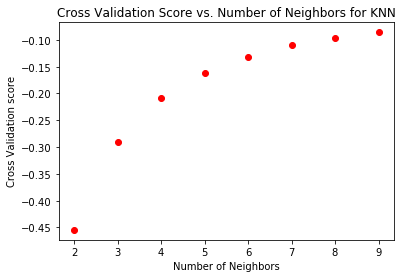

In [21]:
plt.plot(KNN_parameter_tuning_df['Num Neighbors'], KNN_parameter_tuning_df['CV'], 'ro')
plt.title("Cross Validation Score vs. Number of Neighbors for KNN")
plt.ylabel("Cross Validation score")
plt.xlabel("Number of Neighbors")
plt.show()

In [23]:
from sklearn.cluster import KMeans

In [25]:
kmeans1 = KMeans(n_clusters = 3).fit(train_df3)

In [31]:
cluster_centers = pd.DataFrame(kmeans1.cluster_centers_, columns = train_df3.columns, index = [1,2,3])

In [33]:
cluster_centers.head()

,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertylandusetypeid,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyyear,censustractandblock
1,0.038152,0.275260,0.421705,0.113206,0.188992,0.0,0.415037,0.067463,0.0,0.172006,0.075890,0.084313,0.660124,0.082054,0.157866,0.293605,1.823264e-13,0.046971,0.067435,0.075500,0.047079,0.108950,0.517036,0.627404,0.005321,0.0,0.285614,0.0,0.0,0.0,0.944825,0.004738,0.080950,1.000000e+00,0.232521,0.001369,0.000007,0.0,0.002914,0.223337,0.000708,0.107479,0.217874,0.602356,0.146869,0.017696,0.015808,0.0,0.010749,0.018477,0.079577,0.005792
2,0.139451,0.275251,0.421705,0.115887,0.188701,0.0,0.415037,0.071560,0.0,0.172006,0.081240,0.091825,0.660124,0.082056,0.157866,0.293605,2.972973e-01,0.045391,0.061201,0.074718,0.046434,0.171026,0.246604,0.860420,0.001954,0.0,0.285614,0.0,0.0,0.0,0.948437,0.297081,0.069184,-2.513545e-13,0.262719,0.003147,0.201179,0.0,0.003216,0.223337,0.000908,0.107479,0.217874,0.715402,0.141600,0.018283,0.018435,0.0,0.013461,0.019256,0.079658,0.296141
3,0.068031,0.275257,0.421705,0.113706,0.196255,0.0,0.415037,0.071619,0.0,0.172006,0.082787,0.094007,0.660124,0.082078,0.157866,0.293605,1.000000e+00,0.052353,0.062229,0.078163,0.049288,0.127260,0.610523,0.240545,0.002122,0.0,0.285614,0.0,0.0,0.0,0.947688,0.999948,0.071600,4.269972e-01,0.256035,0.003094,0.345315,0.0,0.001889,0.223337,0.000899,0.107479,0.217874,0.721765,0.165363,0.020680,0.015443,0.0,0.009172,0.015330,0.079575,0.989714


A birdie from another script suggested these columns to use instead of the entire dataset. 

This might increase the algorithm performance. 